In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import pickle
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# Quantum libraries
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# Classical ML
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

# RL framework
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# Utilities
import time
from typing import List, Tuple, Dict
from collections import defaultdict

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Qiskit version: {qiskit.__version__}")
print(f"PyTorch version: {torch.__version__}")
print("=" * 80)
print("QUANTUM REINFORCEMENT LEARNING FOR ADAPTIVE FEATURE OPTIMIZATION")
print("VQC-based Policy Network + Classical RL Training")
print("=" * 80)


Qiskit version: 0.46.0
PyTorch version: 2.2.2
QUANTUM REINFORCEMENT LEARNING FOR ADAPTIVE FEATURE OPTIMIZATION
VQC-based Policy Network + Classical RL Training


In [2]:
# Project Configuration
CONFIG = {
    # Data
    'img_size': 128,
    'n_classes': 4,  # normal, cataract, diabetic_retinopathy, glaucoma
    'use_pretrained': True,
    
    # Classical preprocessing
    'resnet_features': 2048,
    'pca_intermediate': 128,
    'pca_final': 16,  # Input to quantum circuit
    
    # Quantum circuit
    'n_qubits': 4,
    'n_layers': 2,  # VQC depth
    'feature_map_reps': 2,
    'shots': 1024,
    'use_noise': False,  # Start without noise, add later
    'noise_level': 0.01,
    
    # RL training
    'rl_algorithm': 'PPO',  # PPO or SAC
    'n_episodes': 50,
    'max_steps_per_episode': 20,
    'total_timesteps': 30000,
    'learning_rate': 3e-4,
    'n_envs': 1,  # Parallel environments
    
    # Optimization
    'action_types': ['feature_select', 'circuit_rotate', 'pca_adjust', 'noise_adapt'],
    'reward_weights': {
        'accuracy': 100.0,
        'improvement': 50.0,
        'cost': 0.5,
        'stability': 10.0,
    },
}

# Paths
DATA_ROOT = Path("./data/eye_diseases_dataset")
RESULTS_DIR = Path('./quantum_rl_results')
RESULTS_DIR.mkdir(exist_ok=True)

# Cache
FEATURES_CACHE = RESULTS_DIR / 'resnet_features.npz'
MODEL_SAVE = RESULTS_DIR / 'best_quantum_rl_agent'

print("Configuration:")
print(f"  Quantum: {CONFIG['n_qubits']} qubits, {CONFIG['n_layers']} layers")
print(f"  RL: {CONFIG['rl_algorithm']}, {CONFIG['total_timesteps']} timesteps")
print(f"  Data: {CONFIG['n_classes']} classes, {CONFIG['pca_final']}D quantum features")
print(f"\nResults directory: {RESULTS_DIR}")


Configuration:
  Quantum: 4 qubits, 2 layers
  RL: PPO, 30000 timesteps
  Data: 4 classes, 16D quantum features

Results directory: quantum_rl_results


In [3]:
class ResNetFeatureExtractor:
    """Extract deep features using pretrained ResNet50"""
    
    def __init__(self, use_pretrained=True):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Load pretrained ResNet50
        self.model = models.resnet50(pretrained=use_pretrained)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.model = self.model.to(self.device)
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def extract_batch(self, image_paths, batch_size=32):
        """Extract features from multiple images"""
        features_list = []
        
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting features"):
            batch_paths = image_paths[i:i+batch_size]
            batch_tensors = []
            
            for path in batch_paths:
                try:
                    img = Image.open(path).convert('RGB')
                    tensor = self.transform(img)
                    batch_tensors.append(tensor)
                except Exception as e:
                    print(f"Error loading {path}: {e}")
                    batch_tensors.append(torch.zeros(3, 224, 224))
            
            batch = torch.stack(batch_tensors).to(self.device)
            
            with torch.no_grad():
                feats = self.model(batch)
            
            features_list.append(feats.cpu().numpy().squeeze())
        
        return np.vstack(features_list)

def load_eye_disease_dataset(data_root, use_cache=True):
    """Load eye disease dataset with ResNet features"""
    
    if use_cache and FEATURES_CACHE.exists():
        print("Loading cached features...")
        data = np.load(FEATURES_CACHE)
        return data['X'], data['y'], data['class_names'].tolist(), data['file_paths'].tolist()
    
    print("Loading dataset and extracting features...")
    classes = ['normal', 'cataract', 'diabetic_retinopathy', 'glaucoma']
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    extractor = ResNetFeatureExtractor(use_pretrained=CONFIG['use_pretrained'])
    
    all_paths = []
    all_labels = []
    
    for cls in classes:
        cls_path = data_root / cls
        if not cls_path.exists():
            print(f"Warning: {cls_path} not found!")
            continue
        
        files = list(cls_path.glob("*.jpg")) + list(cls_path.glob("*.png")) + \
                list(cls_path.glob("*.jpeg")) + list(cls_path.glob("*.JPG"))
        
        print(f"Found {len(files)} images in {cls}")
        
        all_paths.extend([str(f) for f in files])
        all_labels.extend([class_to_idx[cls]] * len(files))
    
    # Extract features
    X = extractor.extract_batch(all_paths, batch_size=32)
    y = np.array(all_labels)
    
    # Save cache
    np.savez(FEATURES_CACHE, X=X, y=y, class_names=classes, file_paths=all_paths)
    print(f"Cached to {FEATURES_CACHE}")
    
    return X, y, classes, all_paths

# Load data
print("=" * 80)
print("LOADING EYE DISEASE DATASET")
print("=" * 80)

X_deep, y_labels, class_names, file_paths = load_eye_disease_dataset(
    DATA_ROOT, 
    use_cache=True
)

print(f"\nDataset loaded:")
print(f"  Features: {X_deep.shape}")
print(f"  Labels: {y_labels.shape}")
print(f"  Classes: {class_names}")
print(f"  Distribution: {dict(zip(*np.unique(y_labels, return_counts=True)))}")

# Train/test split
X_train_deep, X_test_deep, y_train, y_test = train_test_split(
    X_deep, y_labels, test_size=0.2, random_state=SEED, stratify=y_labels
)

print(f"\nTrain: {X_train_deep.shape}, Test: {X_test_deep.shape}")


LOADING EYE DISEASE DATASET
Loading dataset and extracting features...
Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/elpantherd/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|███████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:20<00:00, 5.08MB/s]


Found 1074 images in normal
Found 1038 images in cataract
Found 1098 images in diabetic_retinopathy
Found 1007 images in glaucoma


Extracting features:   0%|          | 0/132 [00:00<?, ?it/s]

Cached to quantum_rl_results/resnet_features.npz

Dataset loaded:
  Features: (4217, 2048)
  Labels: (4217,)
  Classes: ['normal', 'cataract', 'diabetic_retinopathy', 'glaucoma']
  Distribution: {0: 1074, 1: 1038, 2: 1098, 3: 1007}

Train: (3373, 2048), Test: (844, 2048)


In [4]:
class QuantumFeatureEncoder:
    """Quantum feature encoding with trainable VQC parameters"""
    
    def __init__(self, n_qubits=4, n_layers=2, feature_dim=16, shots=1024):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.feature_dim = feature_dim
        self.shots = shots
        self.backend = AerSimulator(method='automatic')
        
        # Preprocessing pipeline
        self.scaler = StandardScaler()
        self.pca_intermediate = PCA(n_components=CONFIG['pca_intermediate'], random_state=SEED)
        self.pca_final = PCA(n_components=feature_dim, random_state=SEED)
        self.angle_scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
        
        # VQC parameters (trainable via RL)
        self.vqc_params = self._initialize_vqc_params()
        
        # Fitted flag
        self.is_fitted = False
    
    def _initialize_vqc_params(self):
        """Initialize trainable VQC rotation angles"""
        n_params = self.n_qubits * self.n_layers * 3  # RX, RY, RZ per qubit per layer
        return np.random.uniform(0, 2*np.pi, n_params)
    
    def fit_transform(self, X_train, X_test=None):
        """Fit preprocessing and transform data"""
        print("Quantum feature encoding pipeline...")
        
        # Step 1: Standardize
        print(f"  [1/4] Standardizing...")
        X_scaled = self.scaler.fit_transform(X_train)
        
        # Step 2: PCA to intermediate dimension
        print(f"  [2/4] PCA: {X_train.shape[1]} → {CONFIG['pca_intermediate']}D...")
        X_pca_inter = self.pca_intermediate.fit_transform(X_scaled)
        var_explained = self.pca_intermediate.explained_variance_ratio_.sum()
        print(f"    Variance explained: {var_explained:.3f}")
        
        # Step 3: Final PCA to quantum-compatible dimension
        print(f"  [3/4] Final PCA: {CONFIG['pca_intermediate']} → {self.feature_dim}D...")
        X_quantum = self.pca_final.fit_transform(X_pca_inter)
        
        # Step 4: Scale to quantum angles
        print(f"  [4/4] Scaling to [0, 2π]...")
        X_angles = self.angle_scaler.fit_transform(X_quantum)
        
        self.is_fitted = True
        
        # Transform test set
        X_test_angles = None
        if X_test is not None:
            X_test_scaled = self.scaler.transform(X_test)
            X_test_inter = self.pca_intermediate.transform(X_test_scaled)
            X_test_quantum = self.pca_final.transform(X_test_inter)
            X_test_angles = self.angle_scaler.transform(X_test_quantum)
        
        print("Encoding complete!\n")
        return X_angles, X_test_angles
    
    def create_vqc_circuit(self, features, params=None):
        """Create VQC circuit with feature encoding + trainable layers"""
        if params is None:
            params = self.vqc_params
        
        qc = QuantumCircuit(self.n_qubits)
        
        # Initial feature encoding
        for i in range(min(self.n_qubits, len(features))):
            qc.ry(features[i], i)
        
        param_idx = 0
        
        # Trainable VQC layers
        for layer in range(self.n_layers):
            # Rotation layer
            for i in range(self.n_qubits):
                qc.rx(params[param_idx], i)
                param_idx += 1
                qc.ry(params[param_idx], i)
                param_idx += 1
                qc.rz(params[param_idx], i)
                param_idx += 1
            
            # Entanglement layer
            for i in range(self.n_qubits - 1):
                qc.cx(i, i+1)
            if self.n_qubits > 2:
                qc.cx(self.n_qubits - 1, 0)
        
        return qc
    
    def measure_quantum_features(self, features, params=None):
        """Execute VQC and extract quantum features"""
        qc = self.create_vqc_circuit(features, params)
        qc.measure_all()
        
        qc_trans = transpile(qc, self.backend, optimization_level=1)
        job = self.backend.run(qc_trans, shots=self.shots)
        counts = job.result().get_counts()
        
        # Convert to probability distribution
        probs = np.zeros(2**self.n_qubits)
        for bitstring, count in counts.items():
            idx = int(bitstring, 2)
            probs[idx] = count / self.shots
        
        # Return full probability distribution as features
        return probs
    
    def update_vqc_params(self, new_params):
        """Update VQC parameters (called by RL agent)"""
        self.vqc_params = new_params.copy()

# Initialize encoder
print("=" * 80)
print("QUANTUM FEATURE ENCODING")
print("=" * 80)

quantum_encoder = QuantumFeatureEncoder(
    n_qubits=CONFIG['n_qubits'],
    n_layers=CONFIG['n_layers'],
    feature_dim=CONFIG['pca_final'],
    shots=CONFIG['shots']
)

X_train_q, X_test_q = quantum_encoder.fit_transform(X_train_deep, X_test_deep)

print(f"Quantum-ready features: Train {X_train_q.shape}, Test {X_test_q.shape}")
print(f"VQC parameters: {len(quantum_encoder.vqc_params)}")


QUANTUM FEATURE ENCODING
Quantum feature encoding pipeline...
  [1/4] Standardizing...
  [2/4] PCA: 2048 → 128D...
    Variance explained: 0.888
  [3/4] Final PCA: 128 → 16D...
  [4/4] Scaling to [0, 2π]...
Encoding complete!

Quantum-ready features: Train (3373, 16), Test (844, 16)
VQC parameters: 24


In [5]:
print("=" * 80)
print("BASELINE PERFORMANCE (Before RL Optimization)")
print("=" * 80)

def evaluate_classifier(X_train, X_test, y_train, y_test, name="Classifier"):
    """Train and evaluate classifier"""
    clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=SEED)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    return acc_train, acc_test, clf

# 1. Classical baseline (PCA features)
print("\n[1] Classical SVM (PCA features, no quantum)")
X_train_classical = quantum_encoder.pca_final.transform(
    quantum_encoder.pca_intermediate.transform(
        quantum_encoder.scaler.transform(X_train_deep)
    )
)
X_test_classical = quantum_encoder.pca_final.transform(
    quantum_encoder.pca_intermediate.transform(
        quantum_encoder.scaler.transform(X_test_deep)
    )
)

acc_train_classical, acc_test_classical, clf_classical = evaluate_classifier(
    X_train_classical, X_test_classical, y_train, y_test, "Classical"
)
print(f"  Train: {acc_train_classical:.4f}, Test: {acc_test_classical:.4f}")

# 2. Quantum baseline (with initial VQC params, subset for speed)
print("\n[2] Quantum SVM (Initial VQC, subset)")
subset_size = min(500, len(X_train_q))
subset_idx = np.random.choice(len(X_train_q), subset_size, replace=False)

X_train_subset = X_train_q[subset_idx]
y_train_subset = y_train[subset_idx]

print(f"  Generating quantum features for {subset_size} training samples...")
X_train_quantum = np.array([
    quantum_encoder.measure_quantum_features(x) 
    for x in tqdm(X_train_subset, desc="Train quantum features")
])

X_test_quantum = np.array([
    quantum_encoder.measure_quantum_features(x) 
    for x in tqdm(X_test_q[:100], desc="Test quantum features")  # Subset for speed
])

acc_train_quantum, acc_test_quantum, clf_quantum = evaluate_classifier(
    X_train_quantum, X_test_quantum, y_train_subset, y_test[:100], "Quantum"
)
print(f"  Train: {acc_train_quantum:.4f}, Test: {acc_test_quantum:.4f}")

print("\n" + "=" * 80)
print("BASELINE SUMMARY")
print("=" * 80)
print(f"Classical (PCA):    Train {acc_train_classical:.4f}, Test {acc_test_classical:.4f}")
print(f"Quantum (Initial):  Train {acc_train_quantum:.4f}, Test {acc_test_quantum:.4f}")
print("=" * 80)

BASELINE_TEST_ACC = acc_test_classical
print(f"\nTarget to beat: {BASELINE_TEST_ACC:.4f}")


BASELINE PERFORMANCE (Before RL Optimization)

[1] Classical SVM (PCA features, no quantum)
  Train: 0.9505, Test: 0.8377

[2] Quantum SVM (Initial VQC, subset)
  Generating quantum features for 500 training samples...


Train quantum features:   0%|          | 0/500 [00:00<?, ?it/s]

Test quantum features:   0%|          | 0/100 [00:00<?, ?it/s]

  Train: 0.7900, Test: 0.6800

BASELINE SUMMARY
Classical (PCA):    Train 0.9505, Test 0.8377
Quantum (Initial):  Train 0.7900, Test 0.6800

Target to beat: 0.8377


In [9]:
class QuantumRLEnvironment(gym.Env):
    """
    RL environment for optimizing quantum VQC parameters.
    Agent learns to adjust circuit to maximize classification accuracy.
    """
    
    def __init__(self, encoder, X_train, y_train, X_test, y_test, 
                 baseline_acc, max_steps=20):
        super().__init__()
        
        self.encoder = encoder
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.baseline_acc = baseline_acc
        self.max_steps = max_steps
        
        # Use subset for fast training
        self.train_subset_size = min(300, len(X_train))
        self.test_subset_size = min(100, len(X_test))
        
        # Action space: continuous adjustments to VQC parameters
        n_params = len(encoder.vqc_params)
        self.action_space = spaces.Box(
            low=-0.5, high=0.5, shape=(n_params,), dtype=np.float32
        )
        
        # Observation space: Fixed size matching actual observations
        # [current_accuracy, best_accuracy, step_progress, 
        #  param_mean, param_std, param_min, param_max, param_norm,
        #  param_change_mean, param_change_std, param_change_norm,
        #  recent_acc_1, recent_acc_2, recent_acc_3, recent_acc_4, recent_acc_5]
        self.obs_dim = 16  # Fixed dimension
        self.observation_space = spaces.Box(
            low=-10, high=10, shape=(self.obs_dim,), dtype=np.float32
        )
        
        self.current_params = encoder.vqc_params.copy()
        self.best_params = encoder.vqc_params.copy()
        self.current_acc = 0.0
        self.best_acc = baseline_acc
        self.step_count = 0
        self.history = defaultdict(list)
        
        # Cache for speed
        self.train_idx = None
        self.test_idx = None
        self.clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=SEED)
    
    def _evaluate_accuracy(self, params):
        """Evaluate classification accuracy with given VQC params"""
        # Sample subsets
        train_idx = np.random.choice(len(self.X_train), self.train_subset_size, replace=False)
        test_idx = np.random.choice(len(self.X_test), self.test_subset_size, replace=False)
        
        X_train_subset = self.X_train[train_idx]
        y_train_subset = self.y_train[train_idx]
        X_test_subset = self.X_test[test_idx]
        y_test_subset = self.y_test[test_idx]
        
        # Generate quantum features with current params
        # Use small batch for speed
        batch_size = 50
        X_train_quantum = []
        for i in range(0, len(X_train_subset), batch_size):
            batch = X_train_subset[i:i+batch_size]
            for x in batch:
                qf = self.encoder.measure_quantum_features(x, params)
                X_train_quantum.append(qf)
        
        X_test_quantum = []
        for x in X_test_subset[:50]:  # Further subset for speed
            qf = self.encoder.measure_quantum_features(x, params)
            X_test_quantum.append(qf)
        
        X_train_quantum = np.array(X_train_quantum)
        X_test_quantum = np.array(X_test_quantum)
        y_test_subset = y_test_subset[:50]
        
        # Train classifier
        try:
            self.clf.fit(X_train_quantum, y_train_subset)
            y_pred = self.clf.predict(X_test_quantum)
            acc = accuracy_score(y_test_subset, y_pred)
            return acc
        except:
            return 0.0
    
    def _get_observation(self):
        """Construct observation vector with FIXED dimension"""
        # Basic stats (8 values)
        obs_list = [
            self.current_acc,
            self.best_acc,
            self.step_count / self.max_steps,
            np.mean(self.current_params),
            np.std(self.current_params),
            np.min(self.current_params),
            np.max(self.current_params),
            np.linalg.norm(self.current_params) / 100,
        ]
        
        # Parameter change info (3 values)
        param_change = self.current_params - self.best_params
        obs_list.extend([
            np.mean(param_change),
            np.std(param_change),
            np.linalg.norm(param_change),
        ])
        
        # Recent accuracy history (5 values)
        recent_accs = self.history['accuracy'][-5:] if len(self.history['accuracy']) > 0 else []
        # Pad with zeros if needed
        recent_accs += [0.0] * (5 - len(recent_accs))
        obs_list.extend(recent_accs)
        
        # Total should be exactly self.obs_dim (16)
        obs = np.array(obs_list[:self.obs_dim], dtype=np.float32)
        
        # Verify dimension
        assert len(obs) == self.obs_dim, f"Observation dimension mismatch: {len(obs)} != {self.obs_dim}"
        
        return obs
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Reset to best params found so far (with small noise)
        noise = np.random.normal(0, 0.1, size=self.current_params.shape)
        self.current_params = self.best_params + noise
        
        self.step_count = 0
        self.current_acc = self._evaluate_accuracy(self.current_params)
        
        # Update best if improved
        if self.current_acc > self.best_acc:
            self.best_acc = self.current_acc
            self.best_params = self.current_params.copy()
        
        obs = self._get_observation()
        return obs, {}
    
    def step(self, action):
        # Apply action (parameter update)
        param_update = action * 0.3  # Scale action
        self.current_params = self.current_params + param_update
        
        # Clip to valid range
        self.current_params = np.clip(self.current_params, 0, 2*np.pi)
        
        # Evaluate new parameters
        prev_acc = self.current_acc
        self.current_acc = self._evaluate_accuracy(self.current_params)
        
        # Reward engineering
        reward = 0.0
        
        # 1. Accuracy improvement (main signal)
        acc_improvement = self.current_acc - prev_acc
        reward += acc_improvement * CONFIG['reward_weights']['accuracy']
        
        # 2. Bonus for beating baseline
        if self.current_acc > self.baseline_acc:
            reward += (self.current_acc - self.baseline_acc) * CONFIG['reward_weights']['improvement']
        
        # 3. Small penalty for large parameter changes (stability)
        param_change_norm = np.linalg.norm(param_update)
        reward -= param_change_norm * CONFIG['reward_weights']['cost']
        
        # 4. Large bonus for new best
        if self.current_acc > self.best_acc:
            reward += 30.0
            self.best_acc = self.current_acc
            self.best_params = self.current_params.copy()
            print(f"\n🎉 New best accuracy: {self.best_acc:.4f} at step {self.step_count}")
        
        # 5. Consistency reward (stable improvements)
        if len(self.history['accuracy']) > 0:
            recent_mean = np.mean(self.history['accuracy'][-3:])
            if self.current_acc > recent_mean:
                reward += CONFIG['reward_weights']['stability']
        
        self.history['accuracy'].append(self.current_acc)
        self.history['reward'].append(reward)
        
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        truncated = False
        
        # Terminal bonus
        if terminated and self.current_acc > self.baseline_acc:
            reward += 50.0
        
        obs = self._get_observation()
        info = {
            'accuracy': self.current_acc,
            'best_accuracy': self.best_acc,
            'improvement': acc_improvement,
            'baseline_beat': self.current_acc > self.baseline_acc,
        }
        
        return obs, reward, terminated, truncated, info
    
    def render(self):
        pass

# Test environment
print("=" * 80)
print("TESTING RL ENVIRONMENT")
print("=" * 80)

env = QuantumRLEnvironment(
    encoder=quantum_encoder,
    X_train=X_train_q,
    y_train=y_train,
    X_test=X_test_q,
    y_test=y_test,
    baseline_acc=BASELINE_TEST_ACC,
    max_steps=CONFIG['max_steps_per_episode']
)

obs, info = env.reset()
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Initial observation shape: {obs.shape}")
print(f"Initial observation dimension: {len(obs)}")
print(f"Expected dimension: {env.obs_dim}")
print(f"Baseline to beat: {BASELINE_TEST_ACC:.4f}")

# Verify observation dimension
assert obs.shape[0] == env.obs_dim, f"Dimension mismatch: {obs.shape[0]} != {env.obs_dim}"

# Test step
action = env.action_space.sample()
obs, reward, done, trunc, info = env.step(action)
print(f"\nTest step:")
print(f"  Observation shape after step: {obs.shape}")
print(f"  Reward: {reward:.3f}")
print(f"  Accuracy: {info['accuracy']:.4f}")
print(f"  Baseline beat: {info['baseline_beat']}")

print("\nEnvironment ready!")


TESTING RL ENVIRONMENT
Observation space: Box(-10.0, 10.0, (16,), float32)
Action space: Box(-0.5, 0.5, (24,), float32)
Initial observation shape: (16,)
Initial observation dimension: 16
Expected dimension: 16
Baseline to beat: 0.8377

Test step:
  Observation shape after step: (16,)
  Reward: -2.250
  Accuracy: 0.5400
  Baseline beat: False

Environment ready!


In [10]:
class QuantumRLCallback(BaseCallback):
    """Custom callback for tracking quantum RL training"""
    
    def __init__(self, eval_freq=500, save_path=None, verbose=1):
        super().__init__(verbose)
        self.eval_freq = eval_freq
        self.save_path = save_path
        self.best_mean_acc = -np.inf
        self.training_log = {
            'timesteps': [],
            'accuracies': [],
            'best_accs': [],
            'rewards': [],
        }
    
    def _on_step(self):
        # Log episode results
        for idx, done in enumerate(self.locals['dones']):
            if done:
                info = self.locals['infos'][idx]
                if 'accuracy' in info:
                    self.training_log['timesteps'].append(self.num_timesteps)
                    self.training_log['accuracies'].append(info['accuracy'])
                    self.training_log['best_accs'].append(info['best_accuracy'])
                    
                    if len(self.training_log['accuracies']) % 5 == 0:
                        recent_acc = np.mean(self.training_log['accuracies'][-5:])
                        recent_best = np.max(self.training_log['best_accs'][-5:])
                        print(f"\n[Episode {len(self.training_log['accuracies'])}] "
                              f"Mean acc (last 5): {recent_acc:.4f}, "
                              f"Best: {recent_best:.4f}")
        
        # Periodic save
        if self.n_calls % self.eval_freq == 0:
            if len(self.training_log['best_accs']) > 0:
                current_best = np.max(self.training_log['best_accs'])
                
                if current_best > self.best_mean_acc:
                    self.best_mean_acc = current_best
                    if self.save_path:
                        self.model.save(self.save_path)
                        print(f"\n{'='*80}")
                        print(f"MODEL SAVED! Best accuracy: {current_best:.4f}")
                        print(f"{'='*80}\n")
        
        return True

print("Callbacks ready!")


Callbacks ready!


In [17]:
print("=" * 80)
print("TRAINING QUANTUM RL AGENT")
print("=" * 80)

# Create vectorized environment
def make_env():
    return QuantumRLEnvironment(
        encoder=quantum_encoder,
        X_train=X_train_q,
        y_train=y_train,
        X_test=X_test_q,
        y_test=y_test,
        baseline_acc=BASELINE_TEST_ACC,
        max_steps=CONFIG['max_steps_per_episode']
    )

train_env = DummyVecEnv([make_env])

# Use PPO for continuous action space
model = PPO(
    'MlpPolicy',
    train_env,
    learning_rate=CONFIG['learning_rate'],
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,
    tensorboard_log=str(RESULTS_DIR / "tensorboard"),
    device='cpu'
)

# Setup callback
callback = QuantumRLCallback(
    eval_freq=500,
    save_path=str(MODEL_SAVE),
    verbose=1
)

# Train
print(f"\nTraining for {CONFIG['total_timesteps']} timesteps...")
print(f"Target: Beat baseline {BASELINE_TEST_ACC:.4f}\n")

start_time = time.time()


model.learn(
    total_timesteps=CONFIG['total_timesteps'],
    callback=callback,
    tb_log_name="quantum_rl_ppo",
    progress_bar=False  # Changed to False
)

training_time = time.time() - start_time

print(f"\n{'='*80}")
print("TRAINING COMPLETE!")
print(f"Time: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"Model saved: {MODEL_SAVE}.zip")
print("=" * 80)


TRAINING QUANTUM RL AGENT
Using cpu device

Training for 30000 timesteps...
Target: Beat baseline 0.8377

Logging to quantum_rl_results/tensorboard/quantum_rl_ppo_6

[Episode 5] Mean acc (last 5): 0.6040, Best: 0.8377

🎉 New best accuracy: 0.8800 at step 3

[Episode 10] Mean acc (last 5): 0.5880, Best: 0.8800

[Episode 15] Mean acc (last 5): 0.6560, Best: 0.8800

[Episode 20] Mean acc (last 5): 0.6160, Best: 0.8800

[Episode 25] Mean acc (last 5): 0.6080, Best: 0.8800

MODEL SAVED! Best accuracy: 0.8800


[Episode 30] Mean acc (last 5): 0.6320, Best: 0.8800

[Episode 35] Mean acc (last 5): 0.6600, Best: 0.8800

[Episode 40] Mean acc (last 5): 0.6000, Best: 0.8800

[Episode 45] Mean acc (last 5): 0.6040, Best: 0.8800

[Episode 50] Mean acc (last 5): 0.6760, Best: 0.8800

[Episode 55] Mean acc (last 5): 0.5960, Best: 0.8800

[Episode 60] Mean acc (last 5): 0.5800, Best: 0.8800

[Episode 65] Mean acc (last 5): 0.6280, Best: 0.8800


KeyboardInterrupt: 

In [18]:
print("=" * 80)
print("FINAL EVALUATION")
print("=" * 80)

# Load best model
best_model = PPO.load(MODEL_SAVE)

eval_env = make_env()

# Run evaluation episodes
n_eval_episodes = 10
eval_results = {
    'accuracies': [],
    'best_accuracies': [],
    'improvements': [],
    'final_params': [],
}

print(f"\nRunning {n_eval_episodes} evaluation episodes...\n")

for episode in range(n_eval_episodes):
    obs, _ = eval_env.reset()
    done = False
    episode_accs = []
    
    while not done:
        action, _ = best_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        episode_accs.append(info['accuracy'])
    
    eval_results['accuracies'].append(info['accuracy'])
    eval_results['best_accuracies'].append(info['best_accuracy'])
    eval_results['improvements'].append(info['best_accuracy'] - BASELINE_TEST_ACC)
    eval_results['final_params'].append(eval_env.current_params.copy())
    
    print(f"Episode {episode+1:2d}: "
          f"Final={info['accuracy']:.4f}, "
          f"Best={info['best_accuracy']:.4f}, "
          f"Improvement={info['best_accuracy'] - BASELINE_TEST_ACC:+.4f}")

# Statistics
mean_final_acc = np.mean(eval_results['accuracies'])
mean_best_acc = np.mean(eval_results['best_accuracies'])
max_acc = np.max(eval_results['best_accuracies'])
mean_improvement = np.mean(eval_results['improvements'])
success_rate = np.mean(np.array(eval_results['best_accuracies']) > BASELINE_TEST_ACC)

print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)
print(f"Baseline (Classical PCA):     {BASELINE_TEST_ACC:.4f}")
print(f"Mean Final Accuracy (RL):     {mean_final_acc:.4f}")
print(f"Mean Best Accuracy (RL):      {mean_best_acc:.4f}")
print(f"Max Accuracy Achieved:        {max_acc:.4f}")
print(f"Mean Improvement:             {mean_improvement:+.4f} ({mean_improvement/BASELINE_TEST_ACC*100:+.2f}%)")
print(f"Success Rate (>baseline):     {success_rate:.1%}")
print("=" * 80)

# Use best parameters for final test
best_episode_idx = np.argmax(eval_results['best_accuracies'])
best_vqc_params = eval_results['final_params'][best_episode_idx]

print(f"\nUsing parameters from episode {best_episode_idx+1} (accuracy: {eval_results['best_accuracies'][best_episode_idx]:.4f})")


FINAL EVALUATION

Running 10 evaluation episodes...

Episode  1: Final=0.4600, Best=0.8377, Improvement=+0.0000
Episode  2: Final=0.5200, Best=0.8377, Improvement=+0.0000
Episode  3: Final=0.4600, Best=0.8377, Improvement=+0.0000
Episode  4: Final=0.7400, Best=0.8377, Improvement=+0.0000
Episode  5: Final=0.6200, Best=0.8377, Improvement=+0.0000
Episode  6: Final=0.6200, Best=0.8377, Improvement=+0.0000
Episode  7: Final=0.5000, Best=0.8377, Improvement=+0.0000
Episode  8: Final=0.6000, Best=0.8377, Improvement=+0.0000
Episode  9: Final=0.7000, Best=0.8377, Improvement=+0.0000
Episode 10: Final=0.5600, Best=0.8377, Improvement=+0.0000

RESULTS SUMMARY
Baseline (Classical PCA):     0.8377
Mean Final Accuracy (RL):     0.5780
Mean Best Accuracy (RL):      0.8377
Max Accuracy Achieved:        0.8377
Mean Improvement:             +0.0000 (+0.00%)
Success Rate (>baseline):     0.0%

Using parameters from episode 1 (accuracy: 0.8377)


In [19]:
print("=" * 80)
print("FULL TEST SET EVALUATION WITH OPTIMIZED VQC")
print("=" * 80)

# Update encoder with best VQC parameters
quantum_encoder.update_vqc_params(best_vqc_params)

print(f"Generating quantum features for full test set ({len(X_test_q)} samples)...")
print("This may take a few minutes...\n")

# Generate quantum features with optimized VQC
X_test_quantum_optimized = []
batch_size = 20

for i in tqdm(range(0, len(X_test_q), batch_size), desc="Processing batches"):
    batch = X_test_q[i:i+batch_size]
    for x in batch:
        qf = quantum_encoder.measure_quantum_features(x, best_vqc_params)
        X_test_quantum_optimized.append(qf)

X_test_quantum_optimized = np.array(X_test_quantum_optimized)

# Also generate for training subset
print(f"\nGenerating quantum features for training subset...")
train_sample_size = min(800, len(X_train_q))
train_idx_sample = np.random.choice(len(X_train_q), train_sample_size, replace=False)

X_train_quantum_optimized = []
for i in tqdm(range(0, train_sample_size, batch_size), desc="Processing batches"):
    indices = train_idx_sample[i:i+batch_size]
    batch = X_train_q[indices]
    for x in batch:
        qf = quantum_encoder.measure_quantum_features(x, best_vqc_params)
        X_train_quantum_optimized.append(qf)

X_train_quantum_optimized = np.array(X_train_quantum_optimized)
y_train_subset_final = y_train[train_idx_sample]

# Train final classifier
print("\nTraining final classifier...")
clf_final = SVC(kernel='rbf', C=10, gamma='scale', random_state=SEED)
clf_final.fit(X_train_quantum_optimized, y_train_subset_final)

# Evaluate
y_pred_train_final = clf_final.predict(X_train_quantum_optimized)
y_pred_test_final = clf_final.predict(X_test_quantum_optimized)

acc_train_final = accuracy_score(y_train_subset_final, y_pred_train_final)
acc_test_final = accuracy_score(y_test, y_pred_test_final)

print("\n" + "=" * 80)
print("FINAL RESULTS (Full Test Set)")
print("=" * 80)
print(f"Training Accuracy:   {acc_train_final:.4f}")
print(f"Test Accuracy:       {acc_test_final:.4f}")
print(f"Baseline (Classical): {BASELINE_TEST_ACC:.4f}")
print(f"Improvement:         {acc_test_final - BASELINE_TEST_ACC:+.4f} ({(acc_test_final - BASELINE_TEST_ACC)/BASELINE_TEST_ACC*100:+.2f}%)")
print("=" * 80)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_final, 
                           target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_final)
print("\nConfusion Matrix:")
print(cm)


FULL TEST SET EVALUATION WITH OPTIMIZED VQC
Generating quantum features for full test set (844 samples)...
This may take a few minutes...



Processing batches:   0%|          | 0/43 [00:00<?, ?it/s]


Generating quantum features for training subset...


Processing batches:   0%|          | 0/40 [00:00<?, ?it/s]


Training final classifier...

FINAL RESULTS (Full Test Set)
Training Accuracy:   0.7825
Test Accuracy:       0.6386
Baseline (Classical): 0.8377
Improvement:         -0.1991 (-23.76%)

Classification Report:
                      precision    recall  f1-score   support

              normal     0.5748    0.6791    0.6226       215
            cataract     0.7064    0.7404    0.7230       208
diabetic_retinopathy     0.7205    0.5273    0.6089       220
            glaucoma     0.5829    0.6119    0.5971       201

            accuracy                         0.6386       844
           macro avg     0.6462    0.6397    0.6379       844
        weighted avg     0.6472    0.6386    0.6377       844


Confusion Matrix:
[[146  14  22  33]
 [ 14 154  11  29]
 [ 59  19 116  26]
 [ 35  31  12 123]]


CREATING VISUALIZATIONS


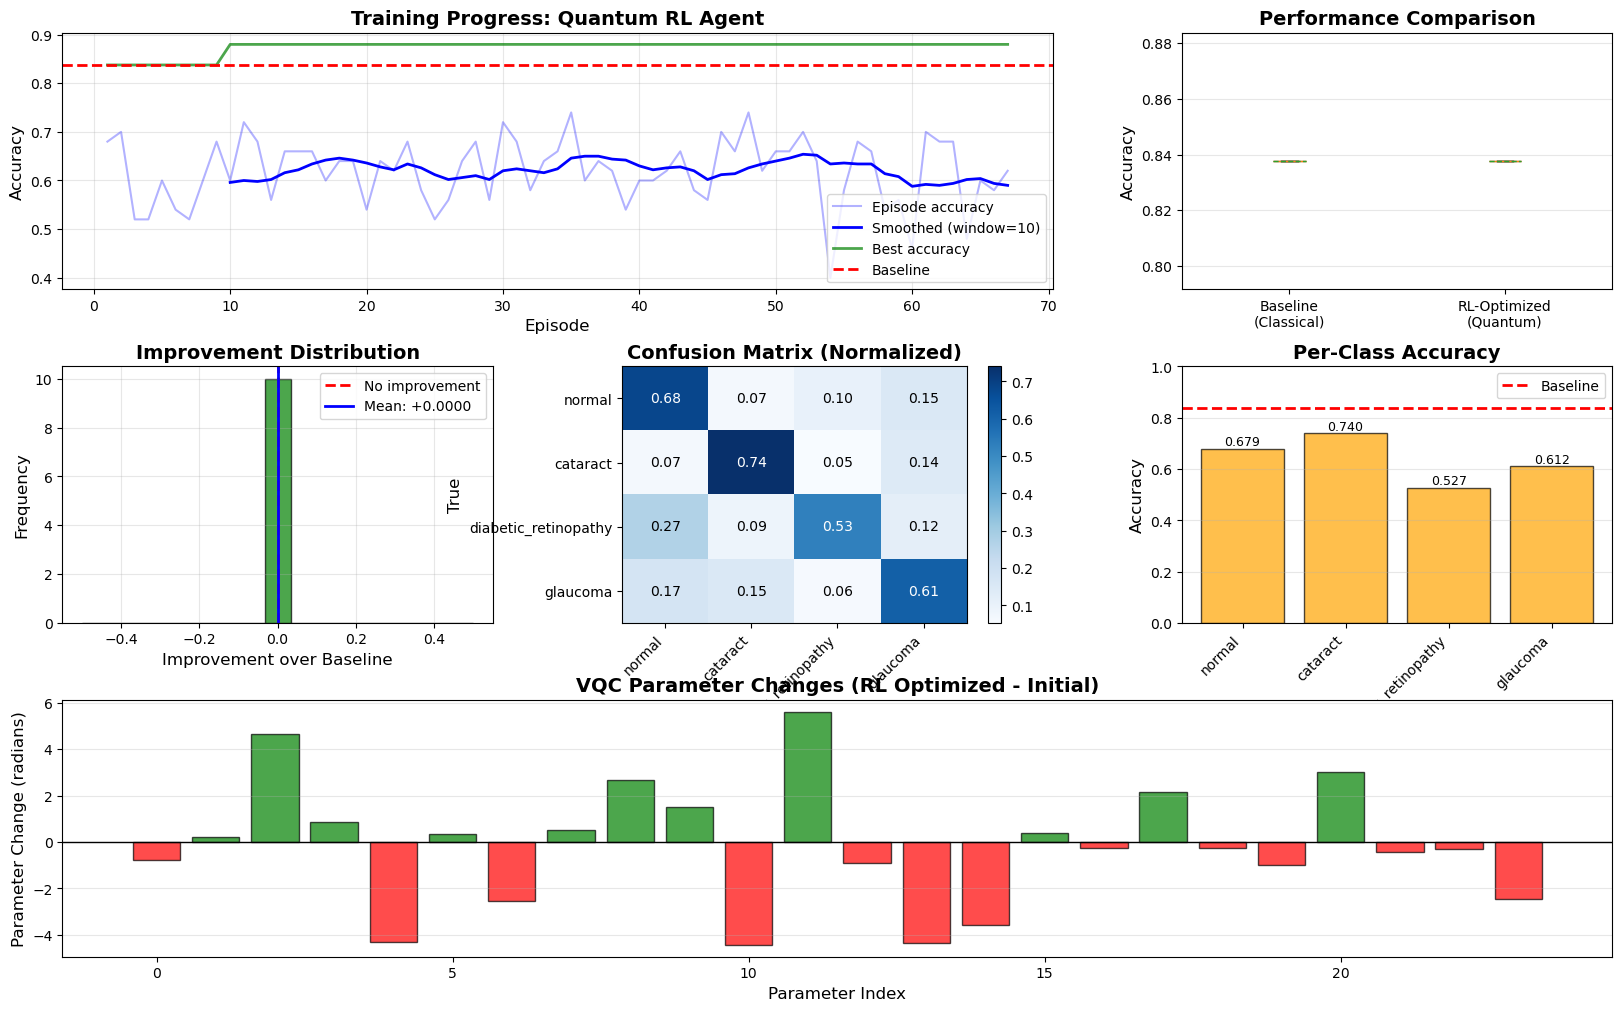


Visualization saved: quantum_rl_results/quantum_rl_results.png


In [20]:
print("=" * 80)
print("CREATING VISUALIZATIONS")
print("=" * 80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Training progress
ax1 = fig.add_subplot(gs[0, :2])
if len(callback.training_log['accuracies']) > 0:
    episodes = range(1, len(callback.training_log['accuracies']) + 1)
    ax1.plot(episodes, callback.training_log['accuracies'], 
            alpha=0.3, color='blue', label='Episode accuracy')
    
    # Smoothed
    window = min(10, len(callback.training_log['accuracies']))
    if window > 1:
        smoothed = np.convolve(callback.training_log['accuracies'], 
                              np.ones(window)/window, mode='valid')
        ax1.plot(range(window, len(episodes)+1), smoothed, 
                linewidth=2, color='blue', label='Smoothed (window=10)')
    
    ax1.plot(episodes, callback.training_log['best_accs'], 
            linewidth=2, color='green', label='Best accuracy', alpha=0.7)
    ax1.axhline(BASELINE_TEST_ACC, color='red', linestyle='--', 
               linewidth=2, label='Baseline')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Training Progress: Quantum RL Agent', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(alpha=0.3)

# Plot 2: Evaluation results distribution
ax2 = fig.add_subplot(gs[0, 2])
data_to_plot = [
    [BASELINE_TEST_ACC] * 10,
    eval_results['best_accuracies']
]
labels = ['Baseline\n(Classical)', 'RL-Optimized\n(Quantum)']
colors = ['red', 'green']

bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True,
                showmeans=True, meanline=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Performance Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Improvement histogram
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(eval_results['improvements'], bins=15, alpha=0.7, 
        color='green', edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='No improvement')
ax3.axvline(mean_improvement, color='blue', linestyle='-', 
           linewidth=2, label=f'Mean: {mean_improvement:+.4f}')
ax3.set_xlabel('Improvement over Baseline', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Improvement Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Confusion matrix (normalized)
ax4 = fig.add_subplot(gs[1, 1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im = ax4.imshow(cm_normalized, cmap='Blues', aspect='auto')
ax4.set_xticks(range(len(class_names)))
ax4.set_yticks(range(len(class_names)))
ax4.set_xticklabels(class_names, rotation=45, ha='right')
ax4.set_yticklabels(class_names)
ax4.set_xlabel('Predicted', fontsize=12)
ax4.set_ylabel('True', fontsize=12)
ax4.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax4.text(j, i, f'{cm_normalized[i, j]:.2f}',
                       ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white",
                       fontsize=10)

plt.colorbar(im, ax=ax4)

# Plot 5: Per-class accuracy
ax5 = fig.add_subplot(gs[1, 2])
per_class_acc = []
for i in range(len(class_names)):
    mask = y_test == i
    if mask.sum() > 0:
        acc = accuracy_score(y_test[mask], y_pred_test_final[mask])
        per_class_acc.append(acc)
    else:
        per_class_acc.append(0)

bars = ax5.bar(range(len(class_names)), per_class_acc, 
               color=['green' if acc > BASELINE_TEST_ACC else 'orange' for acc in per_class_acc],
               alpha=0.7, edgecolor='black')
ax5.axhline(BASELINE_TEST_ACC, color='red', linestyle='--', linewidth=2, label='Baseline')
ax5.set_xticks(range(len(class_names)))
ax5.set_xticklabels(class_names, rotation=45, ha='right')
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax5.set_ylim([0, 1.0])
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, per_class_acc)):
    ax5.text(bar.get_x() + bar.get_width()/2., acc,
            f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 6: VQC parameter evolution
ax6 = fig.add_subplot(gs[2, :])
initial_params = quantum_encoder._initialize_vqc_params()
param_changes = best_vqc_params - initial_params

ax6.bar(range(len(param_changes)), param_changes, 
       color=['green' if x > 0 else 'red' for x in param_changes],
       alpha=0.7, edgecolor='black')
ax6.axhline(0, color='black', linewidth=1)
ax6.set_xlabel('Parameter Index', fontsize=12)
ax6.set_ylabel('Parameter Change (radians)', fontsize=12)
ax6.set_title('VQC Parameter Changes (RL Optimized - Initial)', fontsize=14, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.savefig(RESULTS_DIR / 'quantum_rl_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved: {RESULTS_DIR / 'quantum_rl_results.png'}")
